<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #2: ES models

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 

This practice task is desinged for impriving knowledge of ARIMA models and getting aqcuainted with statistical time series analysis in python.

The task should take about 3-5 hours to be completed.

In [3]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm

import warnings as w
import plotly.plotly as py
from IPython.display import Image

%matplotlib inline

<h1 align="center">1. Reading data (5%)</h1>

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)
     - 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_cunsumption.csv</span> (105 TS of goods sales in shop #36 of one real Retail Net, each TS correspond to an item in shop )
 
 All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ5by4qa_HFqAAoYIg'>link</a> 
 
 
 * For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot each time series
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

In [4]:
ts_wage = pd.read_csv('./monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']

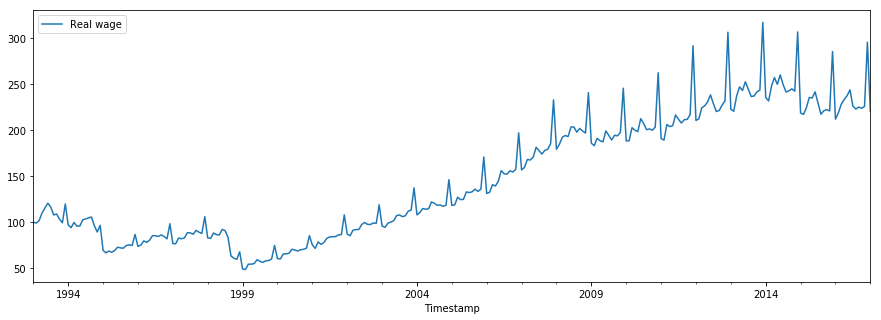

In [7]:
ts_wage.plot(figsize=(15,5))

There is trend, seasonality from 1999 to 2018, seasonality of period 12

In [29]:
energy_ts = pd.read_csv('./energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts.head()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Timestamp,,,,,,,,,,,,,,,,,,,,
2010-01-01,Center,FZSZOE27,147487.171,-17.8,-16.9,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,Center,FZSZOE27,155433.800,-17.8,-20.3,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,Center,FZSZOE27,164140.232,-16.4,-24.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,Center,FZSZOE27,171382.848,-10.2,-15.7,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,Center,FZSZOE27,170188.290,-7.2,-8.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


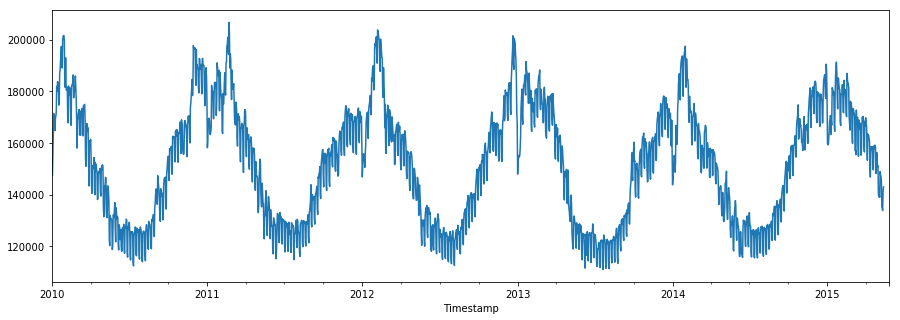

In [27]:
energy_ts['EnergyConsump'].plot(figsize=(15,5))

There is trend ans seasonality, seasonality is period of 12 month, trend is decreasing

<h1 align="center">2. ARIMA Momdel for wage dataset (40%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters your self ** 
Also you can follow the next scheme:
<img src='./ARMA Scheme.png'>


Notes: you need follow to the steps
 * 0) Use data before 01.02.2015 
 * 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
 * 2) Dispersion is stabilized through transformation if needed.
 * 3) If the time series is non-stationary the differentiation degrees is chosen.
 * 4) ACF/PACF are analyzed in order to understand whether AR(p)/MA(q) and seasonal $AR(P)/MA(Q)$  may be used.
 * 5) Candidate models are trained, their AIC/AIC is compared, choose trhe best model.
 * 6) Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested; if the tests fail model modifcations are reviewed.
 * 7) Build forecasts and forecastis interval for period from 01.02.2015 to 01.01.2017
     Calculate loss MACAPE of your Forecast.
     Does the forecast look like appropriate?

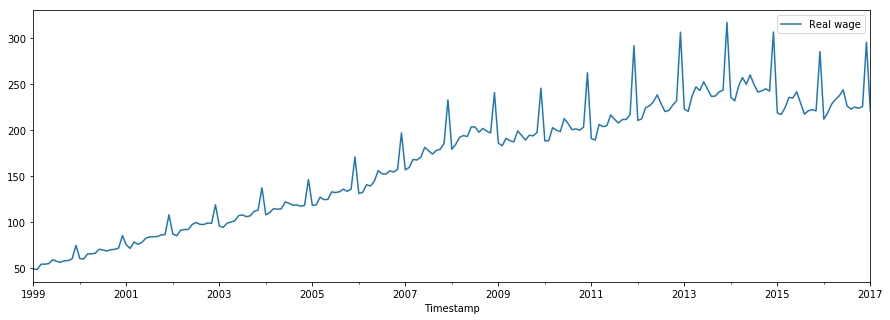

In [93]:
# cut first steps
ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(15,5))

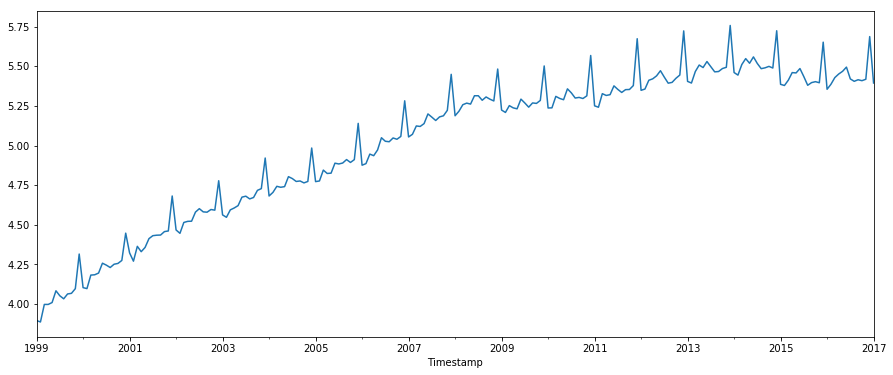

In [145]:
# scaling
from copy import deepcopy
ts_wage_boxcox = deepcopy(ts_wage)
ts_wage_boxcox['wage_boxcox'] = stats.boxcox(ts_wage)[0]
ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage)
ts_wage_boxcox['wage_boxcox'].plot(figsize=(15,6))

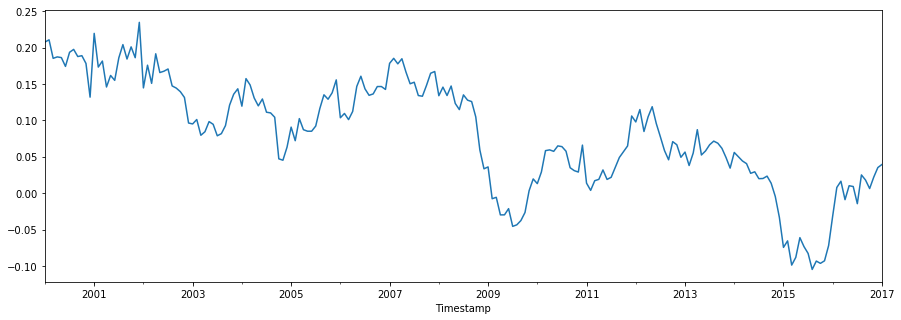

In [146]:
# seasonal differencing
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_ts_wage_boxcox.plot(figsize=(15,5))

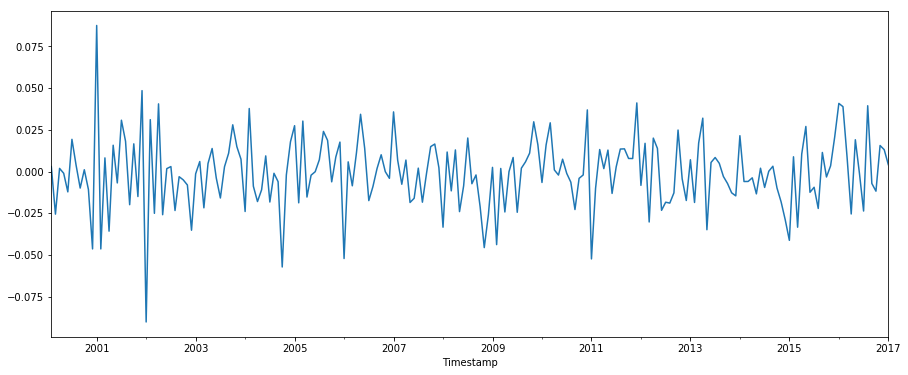

In [147]:
# not stationary yet, diff again 
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot(figsize=(15,6))

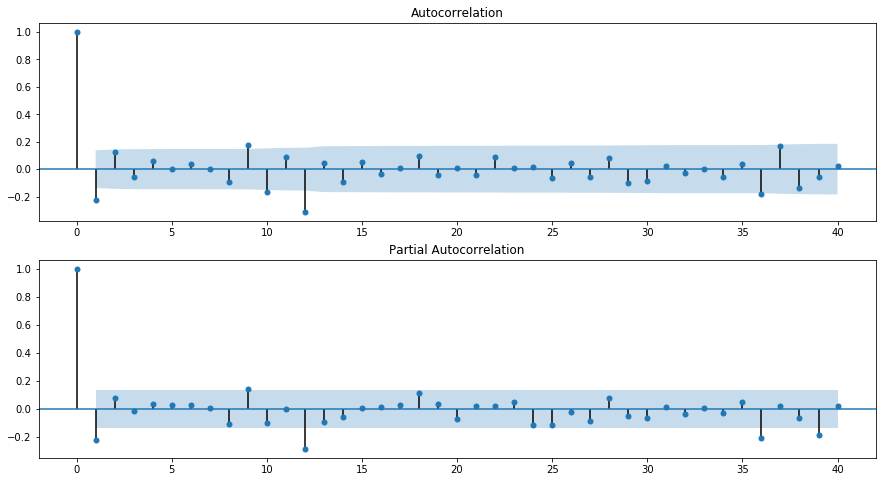

In [157]:
# autocorelation and partial autocorelation
ts = diff_sdiff_ts_wage_boxcox
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.values.squeeze(), lags=40, ax=ax2)

In [296]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(ts))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.062453, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'5%': 0.463, '2.5%': 0.574, '10%': 0.347, '1%': 0.739}


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [297]:
mod = sm.tsa.statespace.SARIMAX(ts_wage, trend='n', order=(1,1,1), seasonal_order=(3,1,3,12))
results = mod.fit()

/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [298]:
results.aic

1151.5693148056444

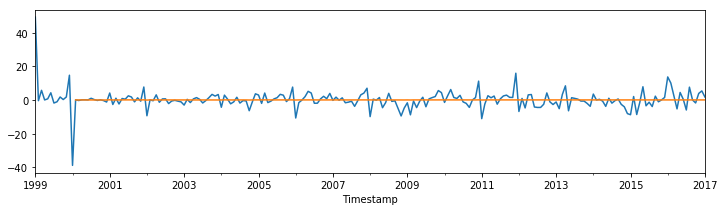

In [299]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax);
ts.plot()

In [300]:
# Darbin_Watson statistic
sm.stats.durbin_watson(results.resid.values)

1.8279671135228914

seems ok

In [301]:
stat = stats.wilcoxon(results.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 11449.000000
pvalue: 0.68


In [302]:
# Normal test
resid = results.resid
stats.normaltest(resid)

NormaltestResult(statistic=133.73781007931154, pvalue=9.103397997708503e-30)

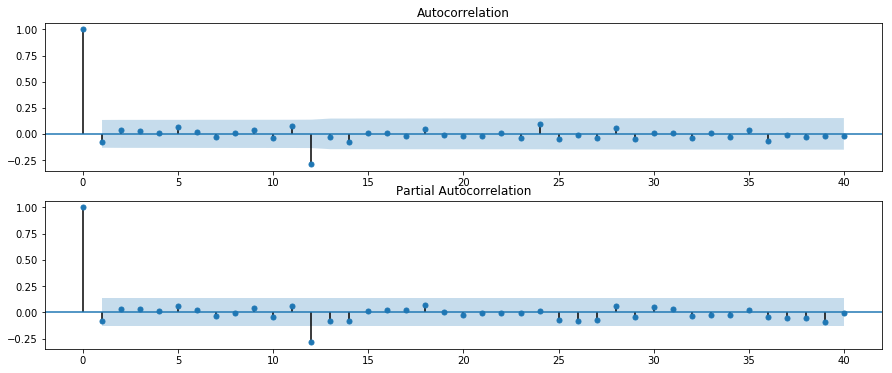

In [303]:
resid = results.resid
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

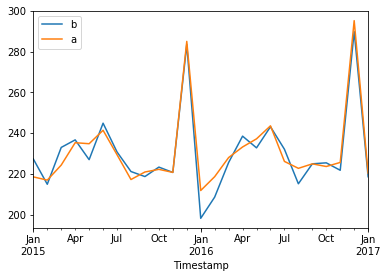

In [304]:
frc_arma = results.predict()
frc_arma = frc_arma.to_frame(name='Real wage')
frc_arma['Real wage'].loc['01.01.2015':'01.01.2017'].plot(label='b')
ts_wage['Real wage'].loc['01.01.2015':'01.01.2017'].plot(label='a')
plt.legend()

prediction from 2015 to 2017

In [305]:
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [306]:
qualityMAPE(frc_arma.loc['01.01.2015':'01.01.2017'], ts_wage.loc['01.01.2015':'01.01.2017'])[0]

Real wage    0.01873
dtype: float64

In [308]:
 qualityMACAPE(frc_arma.loc['01.01.2015':'01.01.2017'], ts_wage.loc['01.01.2015':'01.01.2017'])[0] 

Real wage    0.018613
dtype: float64

seems to be as in SES

**II. Find the best parameters of ARIMA automaticaly** 
* 0) Use data before 01.02.2015 
* 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
* 2) Run grid search for ARIMA parameters (at least for 3 distinct values for $p,q,d, P, Q, D$). 
How many time does it take?
* 4) Find the best set of parameters according to AIC.
* 5) Build the forecast of the best model and it's forecasting interval for period from 01.02.2015 to 01.01.2017.
* 6) Calculate locc MACAPE of your forecast.

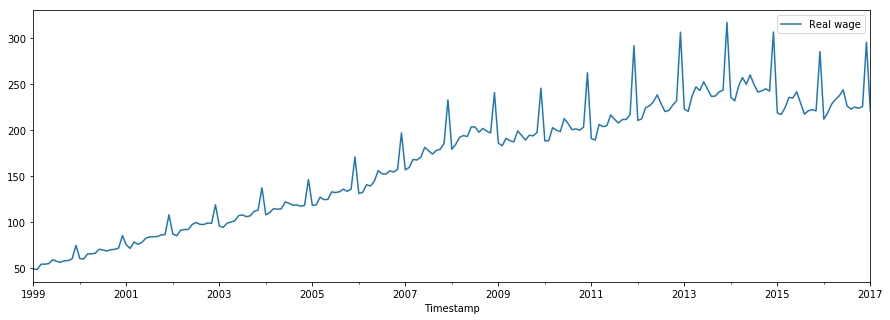

In [309]:
ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(15,5))

In [318]:
def my_func(p,d,q,P,D,Q): 
    try:
        mod = sm.tsa.statespace.SARIMAX(ts_wage.loc[:'03.03.2015'], trend='n', order=(p,d,q), seasonal_order=(P,D,Q,12))
        results = mod.fit()
        frc_arma = results.predict(start = '01.01.2015', end = '01.01.2017')
        frc_arma = frc_arma.to_frame(name='Real wage')
        return str(qualityMAPE(frc_arma.loc['01.01.2015':'01.01.2017'], ts_wage.loc['01.01.2015':'01.01.2017'])[0]['Real wage']) +" " + " ".join([str(p),str(d),str(q),str(P),str(D),str(Q)])
    except Exception:
        return "Can't fit model " + " ".join([str(p),str(d),str(q),str(P),str(D),str(Q)])
    
    

In [531]:
from sklearn.grid_search import ParameterGrid
param_grid = {'p': [1,2], 'd' : [1],
             'q': [1,2], 'P' : [1,3,5],
             'D': [1], 'Q' : [1,3,5]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(my_func(params['p'], params['d'], params['q'], params['P'], params['D'], params['Q']))

0.080988644934 1 1 1 1 1 1


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning:

invalid value encountered in sqrt



nan 1 1 2 1 1 1
0.103615296763 2 1 1 1 1 1
Can't fit model 2 1 2 1 1 1


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.0620439108769 1 1 1 1 1 3
nan 1 1 2 1 1 3


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.0862266202137 2 1 1 1 1 3
Can't fit model 2 1 2 1 1 3
Can't fit model 1 1 1 1 1 5
Can't fit model 1 1 2 1 1 5
Can't fit model 2 1 1 1 1 5
Can't fit model 2 1 2 1 1 5


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:928: RuntimeWarning:

Mean of empty slice.

/home/hp/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



0.064027293955 1 1 1 3 1 1
nan 1 1 2 3 1 1


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.088252001462 2 1 1 3 1 1
Can't fit model 2 1 2 3 1 1
nan 1 1 1 3 1 3
nan 1 1 2 3 1 3
nan 2 1 1 3 1 3
Can't fit model 2 1 2 3 1 3
Can't fit model 1 1 1 3 1 5
Can't fit model 1 1 2 3 1 5
Can't fit model 2 1 1 3 1 5
Can't fit model 2 1 2 3 1 5
0.0550253502571 1 1 1 5 1 1
nan 1 1 2 5 1 1
0.0670407657351 2 1 1 5 1 1
Can't fit model 2 1 2 5 1 1


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.0569905233268 1 1 1 5 1 3
nan 1 1 2 5 1 3


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.0612038315648 2 1 1 5 1 3
Can't fit model 2 1 2 5 1 3
Can't fit model 1 1 1 5 1 5
Can't fit model 1 1 2 5 1 5
Can't fit model 2 1 1 5 1 5
Can't fit model 2 1 2 5 1 5


best seems to be 0.0550253502571 1 1 1 5 1 1 

<h1 align="center">3. ARIMA Momdel for wage dataset (55%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_consumption.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters yourself **
Follow to the steps from 2.I. 

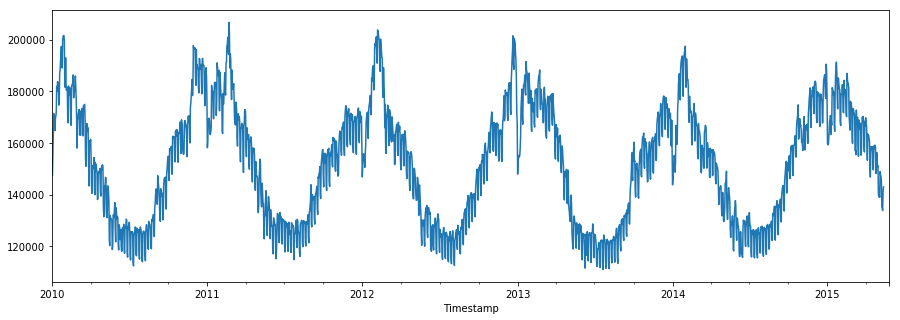

In [322]:
energy_ts = pd.read_csv('./energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts['EnergyConsump'].plot(figsize=(15,5))

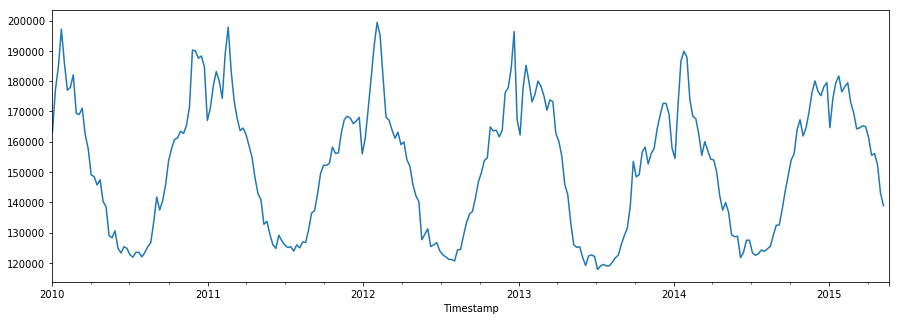

In [332]:
energy_ts['EnergyConsump'].resample("7D").mean().plot(figsize = (15,5))

In [444]:
energy = energy_ts['EnergyConsump']
energy.head()

Timestamp
2010-01-01    147487.171
2010-01-02    155433.800
2010-01-03    164140.232
2010-01-04    171382.848
2010-01-05    170188.290
Name: EnergyConsump, dtype: float64

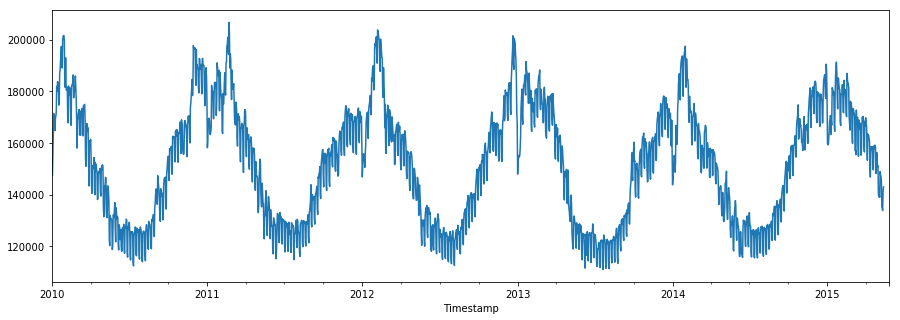

In [445]:
energy.plot(figsize=(15,5))

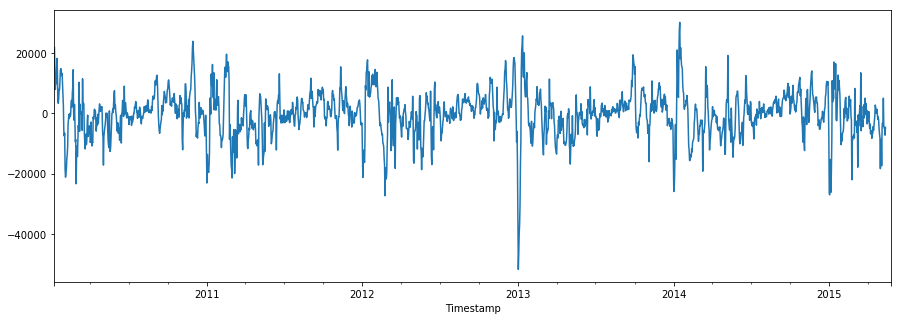

In [446]:
p = 7
energy_shift = (energy - energy.shift(p))[p:]
energy_shift.plot(figsize=(15,5))

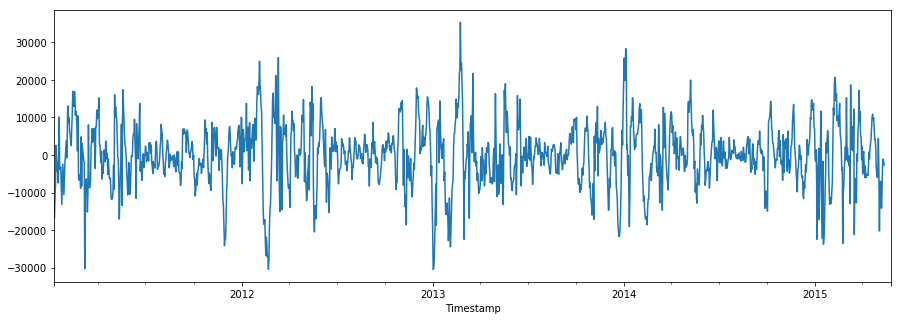

In [447]:
p = 365
energy_shift_1 = (energy_shift - energy_shift.shift(p))[p:]
energy_shift_1.plot(figsize=(15,5))

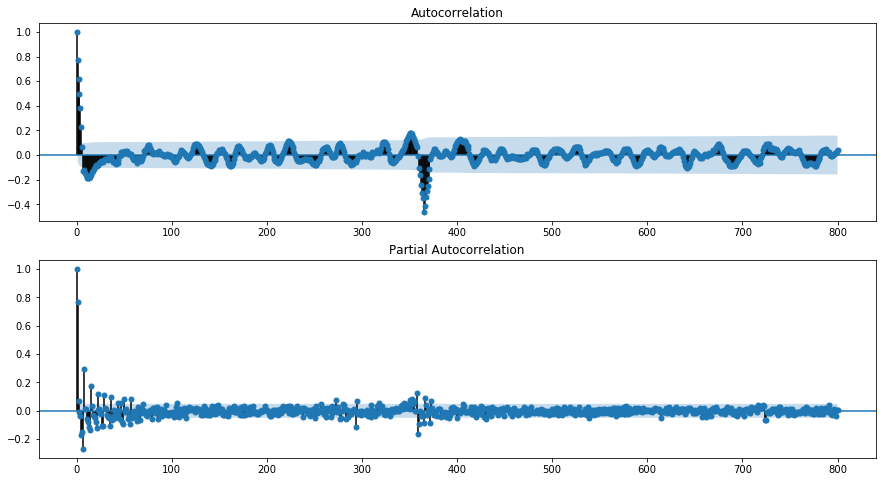

In [449]:
# autocorelation and partial autocorelation
ts = energy_shift_1
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.dropna().values.squeeze(), lags=800, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.dropna().values.squeeze(), lags=800, ax=ax2)

In [450]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(ts.dropna()))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.009940, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'5%': 0.463, '2.5%': 0.574, '10%': 0.347, '1%': 0.739}


/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [451]:
mod = sm.tsa.statespace.SARIMAX(energy, trend='c', order=(1,1,1), seasonal_order=(2,2,2,7), enforce_invertibility=False, enforce_stationarity=False)
results = mod.fit()

In [452]:
results.aic

38346.600017105142

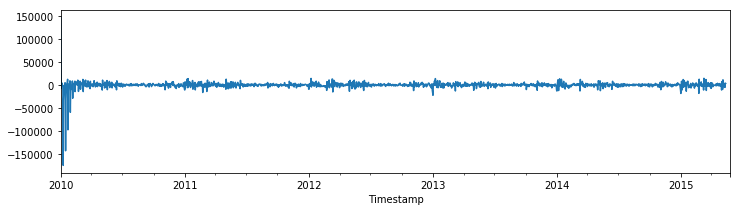

In [453]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax);

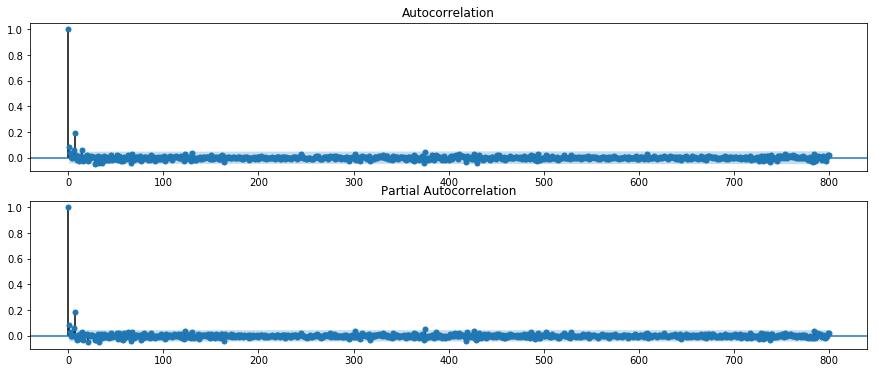

In [454]:
resid = results.resid
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.dropna().values.squeeze(), lags=800, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid.dropna(), lags=800, ax=ax2)

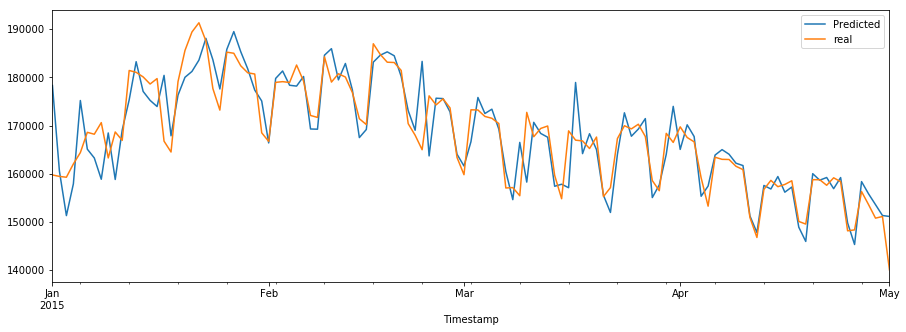

In [461]:
frc_arma = results.predict()
frc_arma.loc['01.01.2015':'05.01.2015'].plot(label='Predicted', figsize = (15,5))
energy.loc['01.01.2015':'05.01.2015'].plot(label='real', figsize = (15,5))
plt.legend()

In [439]:
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [462]:
qualityMAPE(frc_arma.loc['01.01.2015':'05.01.2015'], energy.loc['01.01.2015':'05.01.2015'])[0]

0.021471665214352426

In [463]:
qualityMACAPE(energy.loc['01.01.2015':'05.01.2015'], frc_arma.loc['01.01.2015':'05.01.2015'])[0]

0.021513281005380535

**II. Find the best parameters of ARIMA automaticaly**

I can do it as in previous part, but it will kill my computer, for last part my cpu temps were risen to 90 degree, so , sorry

** III. Adding of exogenious variables**

* 1) Try to add in models from 3.I. and 3.II exogenious variables (at least one of Temp1, Temp2, Saturday and Sunday).
* 2) Does it make accuracy of foreacast for period from 01.02.2015 to 01.01.2017 better?

In [532]:
dta = energy_ts[['EnergyConsump','Temp1', 'Temp2', 'Saturday','Sunday']].dropna()
exogs = dta[['Temp1', 'Temp2', 'Saturday','Sunday']][dta.index<'2015-05-01']
dta = dta[['EnergyConsump']][dta.index<'2015-05-01']

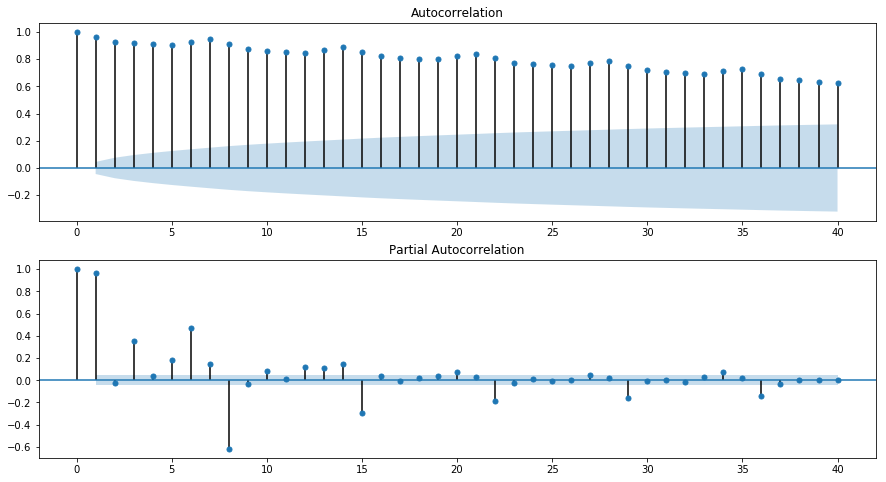

In [533]:
# Use energy data
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.values.squeeze(), lags=40, ax=ax2)

In [540]:
mod = sm.tsa.ARIMA(dta, (7,2,7), exog=exogs)
results = mod.fit()

/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [541]:
results.aic

37764.082591098435

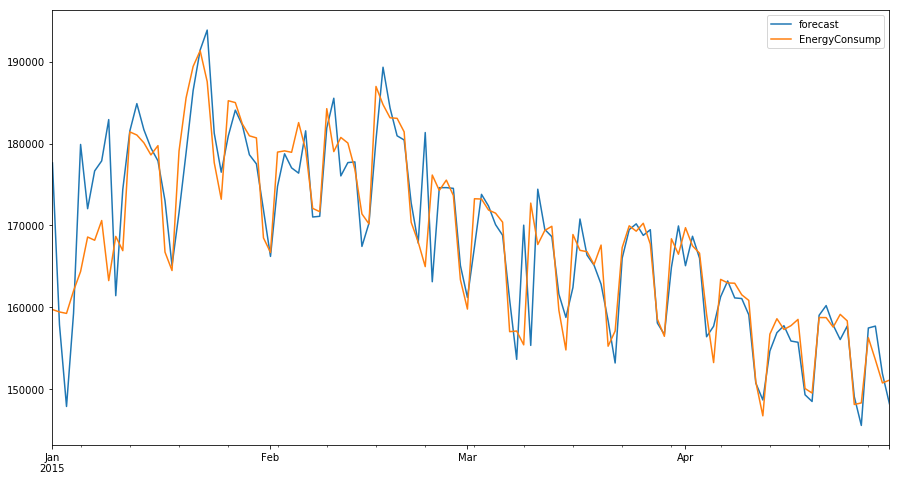

In [542]:
fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
fig = results.plot_predict(start='2015-01-01', end='2015-04-30', ax=ax)

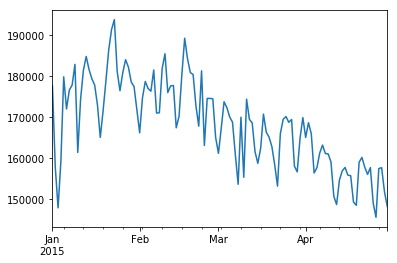

In [543]:
frc_arma = results.predict(start='2015-01-01', end='2015-04-30', typ='levels')
frc_arma.plot()

In [544]:
qualityMAPE(frc_arma.loc['01.01.2015':'05.01.2015'], energy.loc['01.01.2015':'05.01.2015'])[0]

0.01982813547941093

In [545]:
qualityMACAPE(energy.loc['01.01.2015':'05.01.2015'], frc_arma.loc['01.01.2015':'05.01.2015'])[0]

0.019917353463923013

so its better